# 3b Lasso and Ridge Linear Regression with Cross-validation

#### It has four main sections

## A. Imports, data shaping, and preprocessing

## B. Lasso CV regression on all features

## C. Lasso and Ridge regression on all features except `rating count`

## D. Lasso and Ridge regression on all features except `rating count` but with also `budget` added as a feature

# A. Imports and data shaping

In [190]:
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict
#from IPython.core.display import display, HTML
import pickle
import copy
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.model_selection import train_test_split
#display(HTML(my_html))     # make sure Jupyter knows to display it as HTML

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import  StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [191]:
pd.options.display.float_format = "{:,.5f}".format

In [192]:
#director = 'godard'
director = 'hitchcock'
#director = 'bergman'
#director = 'fassbinder'
#director = 'herzog'
#director = 'scorsese'
#director='godard'

In [193]:

dir_str = director + '/'

films_filename = 'films_to_analyze_' + director +'.pickle'
with open(dir_str + films_filename, 'rb') as read_file:
    films_to_analyze = pickle.load(read_file)

In [194]:
films_to_analyze.head()

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Kim Kashkashian,Anton Mossine,Heinz Przbylski,Kerstin Boos,H.J. Jurgen,Uwe Grzechowski,Jochen Gliscinsky,Iva Svarcová,Elfi Gäbel,Carmen Mirando
1,The Image Book,"2,018.00000",25 January 2019 (USA),84.00000,84.00000,NaN,"132,015.00000","132,015.00000",NaN,6.20000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,Ponts de Sarajevo,"2,014.00000",16 July 2014 (France),114.00000,114.00000,"2,100,000.00000",NaN,NaN,NaN,5.80000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,Goodbye to Language,"2,014.00000",28 May 2014 (France),70.00000,70.00000,NaN,"566,423.00000","566,423.00000",NaN,5.90000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
7,3x3D,"2,013.00000",30 April 2014 (France),70.00000,70.00000,NaN,NaN,NaN,NaN,5.80000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
8,Film socialisme,"2,010.00000",19 May 2010 (France),102.00000,102.00000,NaN,"222,079.00000","222,079.00000",NaN,5.70000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [195]:
prevalent_actors_filename  = 'prevalent_actors_' + director +'.pickle'
with open(dir_str + prevalent_actors_filename, 'rb') as read_file:
    prevalent_actor_columns = pickle.load(read_file)

In [196]:
prevalent_actor_columns

Index(['Jean-Luc Godard', 'Anna Karina', 'Anne-Marie Miéville',
       'Anne Wiazemsky', 'Jean-Pierre Léaud', 'László Szabó',
       'Jean-Claude Brialy', 'Jean-Paul Belmondo', 'André S. Labarthe',
       'Juliet Berto', 'Myriem Roussel', 'Jean-Pierre Cassel',
       'Georges Staquet', 'Claude Brasseur'],
      dtype='object')

In [197]:
pickled_dict_of_actors_filename = 'dict_of_actors_' + director +'.pickle'
with open(dir_str + pickled_dict_of_actors_filename, 'rb') as read_file:
    dict_of_all_actors  = pickle.load(read_file) 

In [198]:
analysis_columns = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', *prevalent_actor_columns]

In [199]:
analysis_columns

['title',
 'year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'rating_count',
 'Jean-Luc Godard',
 'Anna Karina',
 'Anne-Marie Miéville',
 'Anne Wiazemsky',
 'Jean-Pierre Léaud',
 'László Szabó',
 'Jean-Claude Brialy',
 'Jean-Paul Belmondo',
 'André S. Labarthe',
 'Juliet Berto',
 'Myriem Roussel',
 'Jean-Pierre Cassel',
 'Georges Staquet',
 'Claude Brasseur']

## Dataset partitioned for analysis
except one-hot-encoding `cinematographer`

In [200]:
films_to_analyze.head()

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Kim Kashkashian,Anton Mossine,Heinz Przbylski,Kerstin Boos,H.J. Jurgen,Uwe Grzechowski,Jochen Gliscinsky,Iva Svarcová,Elfi Gäbel,Carmen Mirando
1,The Image Book,"2,018.00000",25 January 2019 (USA),84.00000,84.00000,NaN,"132,015.00000","132,015.00000",NaN,6.20000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,Ponts de Sarajevo,"2,014.00000",16 July 2014 (France),114.00000,114.00000,"2,100,000.00000",NaN,NaN,NaN,5.80000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,Goodbye to Language,"2,014.00000",28 May 2014 (France),70.00000,70.00000,NaN,"566,423.00000","566,423.00000",NaN,5.90000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
7,3x3D,"2,013.00000",30 April 2014 (France),70.00000,70.00000,NaN,NaN,NaN,NaN,5.80000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
8,Film socialisme,"2,010.00000",19 May 2010 (France),102.00000,102.00000,NaN,"222,079.00000","222,079.00000",NaN,5.70000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [201]:
films_and_features_to_analyze_df = films_to_analyze[analysis_columns]

In [202]:
films_and_features_to_analyze_df.head() 

,title,year,duration,cinematographer,documentary,tv_series,rating,rating_count,Jean-Luc Godard,Anna Karina,...,Jean-Pierre Léaud,László Szabó,Jean-Claude Brialy,Jean-Paul Belmondo,André S. Labarthe,Juliet Berto,Myriem Roussel,Jean-Pierre Cassel,Georges Staquet,Claude Brasseur
1,The Image Book,"2,018.00000",84.00000,Fabrice Aragno,0.00000,0.00000,6.20000,"2,314.00000",1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,Ponts de Sarajevo,"2,014.00000",114.00000,Julian Atanassov,0.00000,0.00000,5.80000,319.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,Goodbye to Language,"2,014.00000",70.00000,Fabrice Aragno,0.00000,0.00000,5.90000,"5,487.00000",0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
7,3x3D,"2,013.00000",70.00000,Luís Branquinho,0.00000,0.00000,5.80000,313.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
8,Film socialisme,"2,010.00000",102.00000,Fabrice Aragno,0.00000,0.00000,5.70000,"2,539.00000",0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [203]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

1

In [204]:
value_counts = films_and_features_to_analyze_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Regression analysis on `rating`,  `duration`, and `year` etc

#### `rating` as target

### Selecting columns for Train Test Split

In [205]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Jean-Luc Godard', 'Anna Karina',
       'Anne-Marie Miéville', 'Anne Wiazemsky', 'Jean-Pierre Léaud',
       'László Szabó', 'Jean-Claude Brialy', 'Jean-Paul Belmondo',
       'André S. Labarthe', 'Juliet Berto', 'Myriem Roussel',
       'Jean-Pierre Cassel', 'Georges Staquet', 'Claude Brasseur'],
      dtype='object')

In [206]:
selected_cols = [*films_and_features_to_analyze_df.columns[1:6], *films_and_features_to_analyze_df.columns[7:]]

In [207]:
selected_cols

['year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating_count',
 'Jean-Luc Godard',
 'Anna Karina',
 'Anne-Marie Miéville',
 'Anne Wiazemsky',
 'Jean-Pierre Léaud',
 'László Szabó',
 'Jean-Claude Brialy',
 'Jean-Paul Belmondo',
 'André S. Labarthe',
 'Juliet Berto',
 'Myriem Roussel',
 'Jean-Pierre Cassel',
 'Georges Staquet',
 'Claude Brasseur']

In [208]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [209]:
y.isnull().values.any()

False

### Train-val vs. test split

In [210]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [211]:
X_test

,year,duration,cinematographer,documentary,tv_series,rating_count,Jean-Luc Godard,Anna Karina,Anne-Marie Miéville,Anne Wiazemsky,Jean-Pierre Léaud,László Szabó,Jean-Claude Brialy,Jean-Paul Belmondo,André S. Labarthe,Juliet Berto,Myriem Roussel,Jean-Pierre Cassel,Georges Staquet,Claude Brasseur
1,"2,018.00000",84.00000,Fabrice Aragno,0.00000,0.00000,"2,314.00000",1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
17,"2,004.00000",80.00000,Julien Hirsch,0.00000,0.00000,"2,814.00000",1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
89,"1,969.00000",102.00000,OTHER,0.00000,0.00000,663.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
40,"1,991.00000",62.00000,OTHER,0.00000,0.00000,641.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
106,"1,965.00000",110.00000,Raoul Coutard,0.00000,0.00000,"29,534.00000",0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
116,"1,963.00000",122.00000,OTHER,0.00000,0.00000,"1,641.00000",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
96,"1,967.00000",105.00000,Raoul Coutard,0.00000,0.00000,"13,124.00000",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75,"1,976.00000",100.00000,OTHER,1.00000,1.00000,55.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
108,"1,965.00000",99.00000,Raoul Coutard,0.00000,0.00000,"22,968.00000",0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
38,"1,991.00000",110.00000,OTHER,0.00000,0.00000,95.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


## Preprocessing

### Categorical Variable Preprocessing

#### One-hot-encoding

In [212]:
cat_ohe_vars = ['cinematographer']
X_train_val_cat_ohe = X_train_val[cat_ohe_vars]
#X_train_cat_ohe 

In [213]:
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_val_cat_ohe)
cat_ohe = ohe.transform(X_train_val_cat_ohe)

In [214]:
columns=ohe.get_feature_names(cat_ohe_vars)
columns

array(['cinematographer_Caroline Champetier',
       'cinematographer_Fabrice Aragno',
       'cinematographer_Jean-Luc Godard', 'cinematographer_Julien Hirsch',
       'cinematographer_OTHER', 'cinematographer_Raoul Coutard',
       'cinematographer_William Lubtchansky'], dtype=object)

In [215]:
X_train_val_cat_ohe_df = pd.DataFrame(cat_ohe, columns=columns, index=X_train_val_cat_ohe.index)
X_train_val_cat_ohe_df.head()

,cinematographer_Caroline Champetier,cinematographer_Fabrice Aragno,cinematographer_Jean-Luc Godard,cinematographer_Julien Hirsch,cinematographer_OTHER,cinematographer_Raoul Coutard,cinematographer_William Lubtchansky
93,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
85,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
28,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
53,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
19,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000


Repeating transformations on testing set

In [216]:
X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cat_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cat_ohe_test, columns=cat_ohe_columns)


### Continuous Variable Preprocessing

In [217]:
cont_column_names = ['year', 'duration', 'rating_count']
X_train_val_cont = X_train_val[cont_column_names ]

X_test_cont      = X_test[     cont_column_names ]


X_train_val_cont.head()


,year,duration,rating_count
93,"1,968.00000",100.00000,"2,791.00000"
85,"1,970.00000",95.00000,556.00000
28,"1,996.00000",84.00000,934.00000
53,"1,987.00000",90.00000,"1,204.00000"
19,"2,002.00000",146.00000,"1,663.00000"


In [218]:
#X_train_val_cont_poly.head()

In [219]:
X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
X_train_val_cont['log_rating_count'] = np.log(X_train_val_cont.rating_count)


X_test_cont['log_year']         = np.log(X_test_cont.year)
X_test_cont['log_rating_count'] = np.log(X_test_cont.rating_count)

<ipython-input-219-d30627963e3a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
<ipython-input-219-d30627963e3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_rating_count'] = np.log(X_train_val_cont.rating_count)
<ipython-input-219-d30627963e3a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [220]:
X_test_cont.shape[0]

12

#### Concatenate columns

In [221]:
cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_val_cat_df = X_train_val[cat_columns]
#X_train_val_cat_df

X_test_cat_df = X_test[cat_columns]
#X_train_val_cat_df

In [222]:
X_test_cat_df.isnull().values.any()

False

In [223]:
X_train_val_combo= pd.concat([X_train_val_cont, X_train_val_cat_ohe_df, X_train_val_cat_df, ], axis='columns')
X_test_combo = pd.concat([X_test_cont.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True), ], axis='columns')

In [224]:
X_test_cat_df.shape

(12, 16)

In [225]:
X_train_val_combo.isnull().values.any()

False

In [226]:
X_test_combo.isnull().values.any()

False

In [227]:
X_test_combo

,year,duration,rating_count,log_year,log_rating_count,cinematographer_Caroline Champetier,cinematographer_Fabrice Aragno,cinematographer_Jean-Luc Godard,cinematographer_Julien Hirsch,cinematographer_OTHER,...,Jean-Pierre Léaud,László Szabó,Jean-Claude Brialy,Jean-Paul Belmondo,André S. Labarthe,Juliet Berto,Myriem Roussel,Jean-Pierre Cassel,Georges Staquet,Claude Brasseur
0,"2,018.00000",84.00000,"2,314.00000",7.60986,7.74673,0.00000,1.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,"2,004.00000",80.00000,"2,814.00000",7.60290,7.94236,0.00000,0.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,"1,969.00000",102.00000,663.00000,7.58528,6.49677,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,"1,991.00000",62.00000,641.00000,7.59639,6.46303,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,"1,965.00000",110.00000,"29,534.00000",7.58325,10.29330,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,"1,963.00000",122.00000,"1,641.00000",7.58223,7.40306,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
6,"1,967.00000",105.00000,"13,124.00000",7.58426,9.48220,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
7,"1,976.00000",100.00000,55.00000,7.58883,4.00733,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
8,"1,965.00000",99.00000,"22,968.00000",7.58325,10.04186,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
9,"1,991.00000",110.00000,95.00000,7.59639,4.55388,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [228]:
selected_columns = X_train_val_combo.columns
X_train_val_combo.columns

Index(['year', 'duration', 'rating_count', 'log_year', 'log_rating_count',
       'cinematographer_Caroline Champetier', 'cinematographer_Fabrice Aragno',
       'cinematographer_Jean-Luc Godard', 'cinematographer_Julien Hirsch',
       'cinematographer_OTHER', 'cinematographer_Raoul Coutard',
       'cinematographer_William Lubtchansky', 'documentary', 'tv_series',
       'Jean-Luc Godard', 'Anna Karina', 'Anne-Marie Miéville',
       'Anne Wiazemsky', 'Jean-Pierre Léaud', 'László Szabó',
       'Jean-Claude Brialy', 'Jean-Paul Belmondo', 'André S. Labarthe',
       'Juliet Berto', 'Myriem Roussel', 'Jean-Pierre Cassel',
       'Georges Staquet', 'Claude Brasseur'],
      dtype='object')

### Train vs. val split

In [229]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val_combo, y_train_val, test_size=.25, random_state=43)

In [230]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

#mae(y_test, test_set_pred)

## B. Lasso CV regression on all features


### Lasso CV

In [231]:
X_train_val_combo.values

array([[1968.,  100., 2791., ...,    0.,    0.,    0.],
       [1970.,   95.,  556., ...,    0.,    0.,    0.],
       [1996.,   84.,  934., ...,    0.,    0.,    0.],
       ...,
       [1972.,   95., 3194., ...,    0.,    0.,    0.],
       [1963.,   80., 2804., ...,    0.,    0.,    0.],
       [1967.,  115.,  653., ...,    0.,    0.,    0.]])

In [232]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train_val_combo.values)

StandardScaler()

In [233]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val_combo.values)
X_te = std.transform(X_test_combo.values)

In [234]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train_val)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [235]:
# This is the best alpha value it found 
lasso_model.alpha_

0.01320088400831418

In [236]:
len(lasso_model.coef_)

28

In [237]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_train.columns, lasso_model.coef_))
coefficients

[('year', -0.0),
 ('duration', 0.02537363170466261),
 ('rating_count', -0.0),
 ('log_year', -0.08852109027813249),
 ('log_rating_count', 0.3873152076054956),
 ('cinematographer_Caroline Champetier', 0.0),
 ('cinematographer_Fabrice Aragno', -0.12691507614260794),
 ('cinematographer_Jean-Luc Godard', -0.05295367963675305),
 ('cinematographer_Julien Hirsch', 0.0),
 ('cinematographer_OTHER', -0.03086513316476311),
 ('cinematographer_Raoul Coutard', 0.07022636053125157),
 ('cinematographer_William Lubtchansky', 0.04629710061894953),
 ('documentary', 0.13553926646335604),
 ('tv_series', 0.08476940707311574),
 ('Jean-Luc Godard', 0.0),
 ('Anna Karina', 0.02815495373196752),
 ('Anne-Marie Miéville', -0.01756779853889),
 ('Anne Wiazemsky', -0.04640598853662455),
 ('Jean-Pierre Léaud', -0.0),
 ('László Szabó', -0.04750293538627322),
 ('Jean-Claude Brialy', -0.047297050367574305),
 ('Jean-Paul Belmondo', 0.0),
 ('André S. Labarthe', 0.10461580445663805),
 ('Juliet Berto', -0.0012942413794428931)

In [238]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [239]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.48630776482803056

In [240]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 

-0.024608710836174996

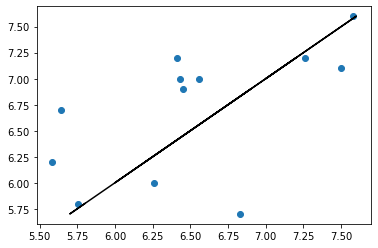

In [241]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

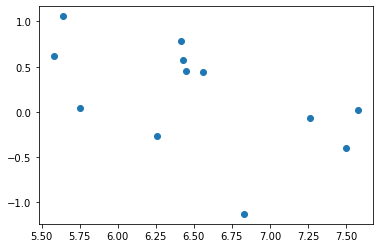

In [242]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)

In [243]:
coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])

coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df.head(20)

,Feature,Coefficient
4,log_rating_count,0.38732
12,documentary,0.13554
6,cinematographer_Fabrice Aragno,-0.12692
22,André S. Labarthe,0.10462
25,Jean-Pierre Cassel,0.09387
26,Georges Staquet,0.08920
3,log_year,-0.08852
13,tv_series,0.08477
10,cinematographer_Raoul Coutard,0.07023
24,Myriem Roussel,-0.06199


In [244]:
Lasso_CV_model_w_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_w_rc 

{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.48630776482803056,
 'coefficients':                                 Feature  Coefficient
 4                      log_rating_count      0.38732
 12                          documentary      0.13554
 6        cinematographer_Fabrice Aragno     -0.12692
 22                    André S. Labarthe      0.10462
 25                   Jean-Pierre Cassel      0.09387
 26                      Georges Staquet      0.08920
 3                              log_year     -0.08852
 13                            tv_series      0.08477
 10        cinematographer_Raoul Coutard      0.07023
 24                       Myriem Roussel     -0.06199
 27                      Claude Brasseur     -0.05826
 7       cinematographer_Jean-Luc Godard     -0.05295
 19                         László Szabó     -0.04750
 20                   Jean-Claude Brialy     -0.047

In [245]:
LCVM_w_rc_filename = 'Lasso_CV_model_w_rc_' + director +'.pickle'
with open(dir_str + LCVM_w_rc_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_w_rc, to_write)

# C. Lasso and Ridge regression on all features except `rating count`



### Rerun the model without using rating count

In [246]:
X_tr = pd.DataFrame(X_tr, columns=X_train.columns )
X_tr.head()

,year,duration,rating_count,log_year,log_rating_count,cinematographer_Caroline Champetier,cinematographer_Fabrice Aragno,cinematographer_Jean-Luc Godard,cinematographer_Julien Hirsch,cinematographer_OTHER,...,Jean-Pierre Léaud,László Szabó,Jean-Claude Brialy,Jean-Paul Belmondo,André S. Labarthe,Juliet Berto,Myriem Roussel,Jean-Pierre Cassel,Georges Staquet,Claude Brasseur
0,-0.66360,0.55327,-0.23231,-0.66364,0.32776,-0.26414,-0.21320,-0.26414,-0.14907,1.14018,...,-0.34922,-0.34922,-0.26414,-0.21320,-0.30861,-0.30861,-0.26414,-0.21320,-0.26414,-0.26414
1,-0.52823,0.24738,-0.41739,-0.52723,-0.74101,-0.26414,-0.21320,-0.26414,-0.14907,1.14018,...,-0.34922,-0.34922,-0.26414,-0.21320,-0.30861,-0.30861,-0.26414,-0.21320,-0.26414,-0.26414
2,1.23155,-0.42560,-0.38609,1.23356,-0.39740,-0.26414,-0.21320,-0.26414,-0.14907,1.14018,...,-0.34922,-0.34922,-0.26414,-0.21320,-0.30861,-0.30861,-0.26414,-0.21320,-0.26414,-0.26414
3,0.62240,-0.05852,-0.36373,0.62667,-0.22919,-0.26414,-0.21320,-0.26414,-0.14907,1.14018,...,-0.34922,-0.34922,-0.26414,-0.21320,-0.30861,-0.30861,-0.26414,-0.21320,-0.26414,-0.26414
4,1.63766,3.36752,-0.32572,1.63664,-0.01524,-0.26414,-0.21320,-0.26414,-0.14907,1.14018,...,-0.34922,-0.34922,-0.26414,-0.21320,-0.30861,-0.30861,-0.26414,-0.21320,-0.26414,-0.26414


In [247]:
X_te = pd.DataFrame(X_te, columns=X_train.columns )

In [248]:
X_tr_no_rc  = X_tr.drop(columns = ['rating_count', 'log_rating_count'])

In [249]:
X_te_no_rc = X_te.drop(columns = ['rating_count', 'log_rating_count'])

In [250]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr_no_rc, y_train_val)

# This is the best alpha value it found 
lasso_model.alpha_

0.0419870708444391

In [251]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_tr_no_rc.columns, lasso_model.coef_))
coefficients_df = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient']).sort_values(by='Coefficient', ascending=False)

In [252]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te_no_rc)

In [253]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.47223712048856137

In [254]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 


0.07560588172636473

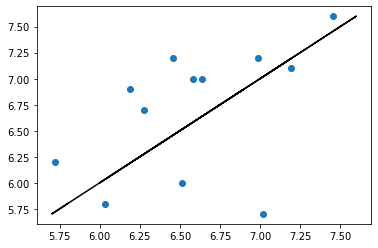

In [255]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')
#plt.plot( x_te_no_rc, y_test, c='k')

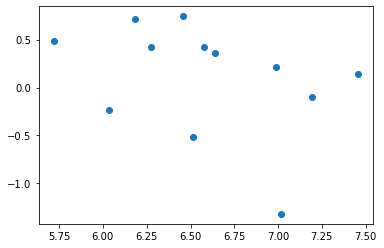

In [256]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)



In [257]:
coefficients_df.head()

,Feature,Coefficient
8,cinematographer_Raoul Coutard,0.20306
20,André S. Labarthe,0.10309
24,Georges Staquet,0.07943
13,Anna Karina,0.05799
19,Jean-Paul Belmondo,0.05352


In [258]:
Lasso_CV_model_no_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_no_rc 


{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.47223712048856137,
 'coefficients':                                 Feature  Coefficient
 8         cinematographer_Raoul Coutard      0.20306
 20                    André S. Labarthe      0.10309
 24                      Georges Staquet      0.07943
 13                          Anna Karina      0.05799
 19                   Jean-Paul Belmondo      0.05352
 10                          documentary      0.04171
 11                            tv_series      0.01695
 9   cinematographer_William Lubtchansky      0.01640
 6         cinematographer_Julien Hirsch      0.00793
 1                              duration      0.00000
 23                   Jean-Pierre Cassel      0.00000
 21                         Juliet Berto     -0.00000
 16                    Jean-Pierre Léaud     -0.00000
 0                                  year     -0.000

In [259]:
LCVM_no_rc_filename = 'Lasso_CV_model_no_rc_' + director +'.pickle'
with open(dir_str + LCVM_no_rc_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_no_rc, to_write)

In [260]:
from sklearn.linear_model import lars_path
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(np.array(X_tr_no_rc), y_train_val.values, method='lasso')

Computing regularization path using the LARS ...


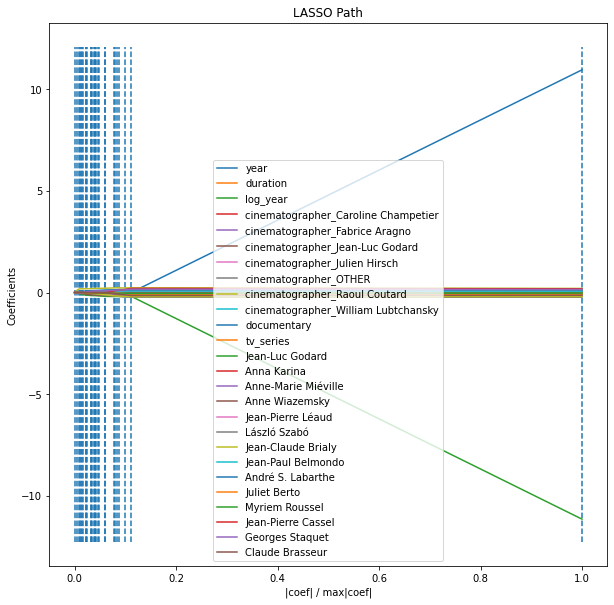

In [261]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_tr_no_rc.columns)
plt.show()

### Ridge regression

In [262]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr_no_rc, y_train_val)

# This is the best alpha value it found 
ridge_model.alpha_

15.702901247293775

In [263]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_tr_no_rc.columns, ridge_model.coef_))

coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])

coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df

,Feature,Coefficient
8,cinematographer_Raoul Coutard,0.14695
5,cinematographer_Jean-Luc Godard,-0.14026
20,André S. Labarthe,0.10935
17,László Szabó,-0.10881
18,Jean-Claude Brialy,-0.10589
2,log_year,-0.09050
0,year,-0.08999
24,Georges Staquet,0.08918
13,Anna Karina,0.08530
19,Jean-Paul Belmondo,0.07096


In [264]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_te_no_rc)

In [265]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.5022565942019751

In [266]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 


-0.14947640026843168

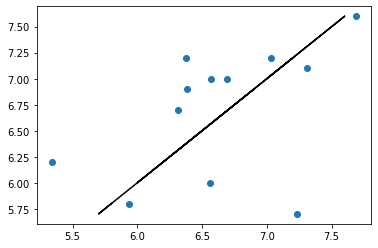

In [267]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

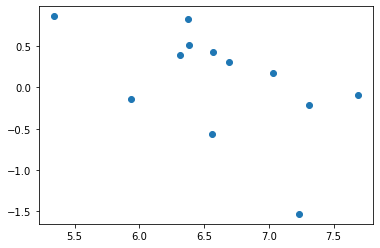

In [268]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)


In [269]:
coefficients_df.head()

,Feature,Coefficient
8,cinematographer_Raoul Coutard,0.14695
5,cinematographer_Jean-Luc Godard,-0.14026
20,André S. Labarthe,0.10935
17,László Szabó,-0.10881
18,Jean-Claude Brialy,-0.10589


In [270]:
Ridge_CV_model_no_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Ridge_CV_model_no_rc 


{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.5022565942019751,
 'coefficients':                                 Feature  Coefficient
 8         cinematographer_Raoul Coutard      0.14695
 5       cinematographer_Jean-Luc Godard     -0.14026
 20                    André S. Labarthe      0.10935
 17                         László Szabó     -0.10881
 18                   Jean-Claude Brialy     -0.10589
 2                              log_year     -0.09050
 0                                  year     -0.08999
 24                      Georges Staquet      0.08918
 13                          Anna Karina      0.08530
 19                   Jean-Paul Belmondo      0.07096
 14                  Anne-Marie Miéville     -0.07036
 7                 cinematographer_OTHER     -0.05446
 10                          documentary      0.05300
 4        cinematographer_Fabrice Aragno     -0.0462

In [271]:
RCVM_no_rc_filename = 'Ridge_CV_model_no_rc_' + director +'.pickle'
with open(dir_str + RCVM_no_rc_filename, 'wb') as to_write:
    pickle.dump(Ridge_CV_model_no_rc, to_write)

# D. Lasso and Ridge regression on all features except `rating count` but with also `budget` added as a feature

#### Re-analyzed including `budget` as a feature 
This entails a fewer rows of data, since many of the films don't have budget info available on IMDB

In [272]:
films_to_analyze_financial_df = films_to_analyze[(films_to_analyze['budget'] > 0) & (films_to_analyze['worldwide_gross'] > 0)]

In [273]:
analysis_columns = ['title', 'year', 'duration', 'budget', 'cinematographer', 'documentary', 'tv_series','rating', *prevalent_actor_columns]

In [274]:
analysis_columns 

['title',
 'year',
 'duration',
 'budget',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'Jean-Luc Godard',
 'Anna Karina',
 'Anne-Marie Miéville',
 'Anne Wiazemsky',
 'Jean-Pierre Léaud',
 'László Szabó',
 'Jean-Claude Brialy',
 'Jean-Paul Belmondo',
 'André S. Labarthe',
 'Juliet Berto',
 'Myriem Roussel',
 'Jean-Pierre Cassel',
 'Georges Staquet',
 'Claude Brasseur']

In [275]:
films_and_features_to_analyze_df = films_to_analyze_financial_df[analysis_columns]

In [276]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

1

In [277]:
value_counts = films_and_features_to_analyze_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Regression analysis on `rating`,  `duration`, `year` and `budget` etc

In [278]:
films_and_features_to_analyze_df.columns

Index(['title', 'year', 'duration', 'budget', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'Jean-Luc Godard', 'Anna Karina',
       'Anne-Marie Miéville', 'Anne Wiazemsky', 'Jean-Pierre Léaud',
       'László Szabó', 'Jean-Claude Brialy', 'Jean-Paul Belmondo',
       'André S. Labarthe', 'Juliet Berto', 'Myriem Roussel',
       'Jean-Pierre Cassel', 'Georges Staquet', 'Claude Brasseur'],
      dtype='object')

In [279]:
selected_cols = [*films_and_features_to_analyze_df.columns[1:7], *films_and_features_to_analyze_df.columns[8:]]

In [280]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [281]:
X

,year,duration,budget,cinematographer,documentary,tv_series,Jean-Luc Godard,Anna Karina,Anne-Marie Miéville,Anne Wiazemsky,Jean-Pierre Léaud,László Szabó,Jean-Claude Brialy,Jean-Paul Belmondo,André S. Labarthe,Juliet Berto,Myriem Roussel,Jean-Pierre Cassel,Georges Staquet,Claude Brasseur
53,"1,987.00000",90.00000,"2,000,000.00000",OTHER,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
103,"1,966.00000",90.00000,"50,000.00000",Raoul Coutard,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
106,"1,965.00000",110.00000,"300,000.00000",Raoul Coutard,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
108,"1,965.00000",99.00000,"220,000.00000",Raoul Coutard,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
112,"1,964.00000",95.00000,"120,000.00000",Raoul Coutard,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000
114,"1,963.00000",102.00000,"900,000.00000",Raoul Coutard,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
117,"1,963.00000",88.00000,"180,000.00000",Raoul Coutard,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
119,"1,962.00000",85.00000,"64,000.00000",Raoul Coutard,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
122,"1,961.00000",84.00000,"160,000.00000",Raoul Coutard,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
125,"1,960.00000",90.00000,"400,000.00000",Raoul Coutard,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [282]:
y.isnull().values.any()

False

In [283]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [284]:
# X_train_val

## Preprocessing


### Categorical Variable Preprocessing

#### One-hot-encoding

In [285]:
cat_ohe_vars = ['cinematographer']
X_train_val_cat_ohe = X_train_val[cat_ohe_vars]
#X_train_cat_ohe 

In [286]:
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_val_cat_ohe)
cat_ohe = ohe.transform(X_train_val_cat_ohe)

In [287]:
columns=ohe.get_feature_names(cat_ohe_vars)
columns

array(['cinematographer_OTHER', 'cinematographer_Raoul Coutard'],
      dtype=object)

In [288]:
cat_ohe.shape[0]

8

In [289]:
X_train_val_cat_ohe.shape[0]

8

In [290]:
X_train_val_cat_ohe_df = pd.DataFrame(cat_ohe, columns=columns, index=X_train_val_cat_ohe.index)
X_train_val_cat_ohe_df.head()

,cinematographer_OTHER,cinematographer_Raoul Coutard
114,0.00000,1.00000
53,1.00000,0.00000
119,0.00000,1.00000
106,0.00000,1.00000
125,0.00000,1.00000


In [291]:
X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cat_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cat_ohe_test, columns=cat_ohe_columns)


### Continuous Variable Preprocessing

In [292]:
cont_column_names = ['year', 'duration', 'budget']
X_train_val_cont = X_train_val[cont_column_names ]

X_test_cont      = X_test[     cont_column_names ]


X_train_val_cont.head()

,year,duration,budget
114,"1,963.00000",102.00000,"900,000.00000"
53,"1,987.00000",90.00000,"2,000,000.00000"
119,"1,962.00000",85.00000,"64,000.00000"
106,"1,965.00000",110.00000,"300,000.00000"
125,"1,960.00000",90.00000,"400,000.00000"


In [293]:
X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
X_train_val_cont['log_budget']         = np.log(X_train_val_cont.budget)
X_train_val_cont['budget_sq'] = X_train_val_cont.budget**2
#X_train_val_cont['budget_per_year'] = X_train_val_cont.budget/X_train_val_cont.year


X_test_cont['log_year']         = np.log(X_test_cont.year)
X_test_cont['log_budget']         = np.log(X_test_cont.budget)
X_test_cont['budget_sq']  =  X_test_cont.budget**2
#X_test_cont['budget_per_year']  =   X_test_cont.budget/X_test_cont.year

<ipython-input-293-02b26dca41c8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
<ipython-input-293-02b26dca41c8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_budget']         = np.log(X_train_val_cont.budget)
<ipython-input-293-02b26dca41c8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [294]:
X_test_cont.shape[0]

2

#### Concatenate columns

In [295]:
cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_val_cat_df = X_train_val[cat_columns]
#X_train_val_cat_df

X_test_cat_df = X_test[cat_columns]
#X_train_val_cat_df

In [296]:
X_test_cat_df.isnull().values.any()

False

In [297]:
X_train_val_combo= pd.concat([X_train_val_cont, X_train_val_cat_ohe_df, X_train_val_cat_df, ], axis='columns')
X_test_combo = pd.concat([X_test_cont.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True), ], axis='columns')

In [298]:
X_test_cat_df.shape

(2, 16)

In [299]:
X_train_val_combo.isnull().values.any()

False

In [300]:
X_test_combo.isnull().values.any()

False

In [301]:
X_test_combo

,year,duration,budget,log_year,log_budget,budget_sq,cinematographer_OTHER,cinematographer_Raoul Coutard,documentary,tv_series,...,Jean-Pierre Léaud,László Szabó,Jean-Claude Brialy,Jean-Paul Belmondo,André S. Labarthe,Juliet Berto,Myriem Roussel,Jean-Pierre Cassel,Georges Staquet,Claude Brasseur
0,"1,961.00000",84.00000,"160,000.00000",7.58121,11.98293,"25,600,000,000.00000",0.00000,1.00000,0.00000,0.00000,...,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,"1,966.00000",90.00000,"50,000.00000",7.58376,10.81978,"2,500,000,000.00000",0.00000,1.00000,0.00000,0.00000,...,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [302]:
selected_columns = X_train_val_combo.columns
X_train_val_combo.columns

Index(['year', 'duration', 'budget', 'log_year', 'log_budget', 'budget_sq',
       'cinematographer_OTHER', 'cinematographer_Raoul Coutard', 'documentary',
       'tv_series', 'Jean-Luc Godard', 'Anna Karina', 'Anne-Marie Miéville',
       'Anne Wiazemsky', 'Jean-Pierre Léaud', 'László Szabó',
       'Jean-Claude Brialy', 'Jean-Paul Belmondo', 'André S. Labarthe',
       'Juliet Berto', 'Myriem Roussel', 'Jean-Pierre Cassel',
       'Georges Staquet', 'Claude Brasseur'],
      dtype='object')

### Train vs. val split



In [303]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val_combo, y_train_val, test_size=.25, random_state=43) #43

### Lasso CV

In [304]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train_val_combo.values)

StandardScaler()

In [305]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val_combo.values)
X_te = std.transform(X_test_combo.values)

In [306]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train_val)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [307]:
# This is the best alpha value it found 
lasso_model.alpha_

0.015885651294280528

In [308]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_train_val_combo.columns, lasso_model.coef_))
coefficients

[('year', -0.4599425765420248),
 ('duration', 0.0),
 ('budget', 0.0),
 ('log_year', -0.0027023939461738415),
 ('log_budget', -0.0),
 ('budget_sq', -0.0),
 ('cinematographer_OTHER', -0.0),
 ('cinematographer_Raoul Coutard', 0.0),
 ('documentary', 0.0),
 ('tv_series', 0.0),
 ('Jean-Luc Godard', -0.20343485291229088),
 ('Anna Karina', -0.024620252953200642),
 ('Anne-Marie Miéville', 0.0),
 ('Anne Wiazemsky', 0.0),
 ('Jean-Pierre Léaud', 0.0),
 ('László Szabó', -0.0630067587561617),
 ('Jean-Claude Brialy', 0.0),
 ('Jean-Paul Belmondo', 0.08862859579965897),
 ('André S. Labarthe', 0.18705285485028472),
 ('Juliet Berto', 0.0),
 ('Myriem Roussel', 0.0),
 ('Jean-Pierre Cassel', 0.0),
 ('Georges Staquet', 0.09359589586320344),
 ('Claude Brasseur', 7.84095011141517e-16)]

In [309]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [310]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.4608254403810683

In [311]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 

0.15426584459696058

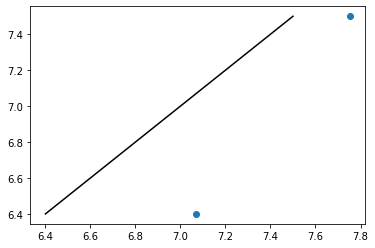

In [312]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

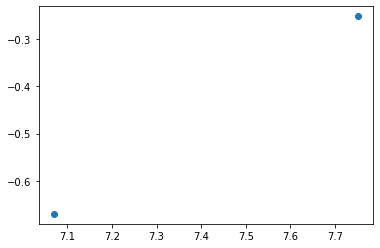

In [313]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)

In [314]:
pd.options.display.float_format = "{:,.5f}".format



In [315]:
coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])
coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df.head(10)
#print(coefficients_df.head(10))

,Feature,Coefficient
0,year,-0.45994
10,Jean-Luc Godard,-0.20343
18,André S. Labarthe,0.18705
22,Georges Staquet,0.09360
17,Jean-Paul Belmondo,0.08863
15,László Szabó,-0.06301
11,Anna Karina,-0.02462
3,log_year,-0.00270
23,Claude Brasseur,0.00000
9,tv_series,0.00000


In [316]:
Lasso_CV_model_w_budget = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_w_budget 

{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.4608254403810683,
 'coefficients':                           Feature  Coefficient
 0                            year     -0.45994
 10                Jean-Luc Godard     -0.20343
 18              André S. Labarthe      0.18705
 22                Georges Staquet      0.09360
 17             Jean-Paul Belmondo      0.08863
 15                   László Szabó     -0.06301
 11                    Anna Karina     -0.02462
 3                        log_year     -0.00270
 23                Claude Brasseur      0.00000
 9                       tv_series      0.00000
 8                     documentary      0.00000
 7   cinematographer_Raoul Coutard      0.00000
 1                        duration      0.00000
 13                 Anne Wiazemsky      0.00000
 14              Jean-Pierre Léaud      0.00000
 6           cinematographer_OTHER     -

In [317]:
LCVM_w_budget_filename = 'Lasso_CV_model_w_budget_' + director +'.pickle'
with open(dir_str + LCVM_w_budget_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_w_budget, to_write)

### Ridge regression

In [318]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y_train_val)

# This is the best alpha value it found 
ridge_model.alpha_

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not w

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not w

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not w

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not w

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not w

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not w

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not w

0.01

In [319]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_train.columns, ridge_model.coef_))


In [320]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_te)

In [321]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.4371651563108143

In [322]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 

-0.06934811425375909

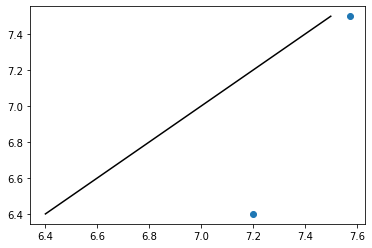

In [323]:

plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

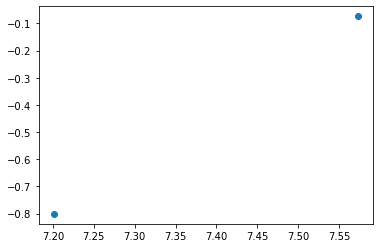

In [324]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)

In [325]:
coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])
coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df.head(10)

,Feature,Coefficient
10,Jean-Luc Godard,-0.42046
18,André S. Labarthe,0.34752
17,Jean-Paul Belmondo,0.18090
11,Anna Karina,-0.16707
3,log_year,-0.14689
0,year,-0.14651
2,budget,0.12953
4,log_budget,-0.10033
22,Georges Staquet,0.09111
23,Claude Brasseur,0.09111


In [326]:
Ridge_CV_model_w_budget = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Ridge_CV_model_w_budget 

{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.4371651563108143,
 'coefficients':                           Feature  Coefficient
 10                Jean-Luc Godard     -0.42046
 18              André S. Labarthe      0.34752
 17             Jean-Paul Belmondo      0.18090
 11                    Anna Karina     -0.16707
 3                        log_year     -0.14689
 0                            year     -0.14651
 2                          budget      0.12953
 4                      log_budget     -0.10033
 22                Georges Staquet      0.09111
 23                Claude Brasseur      0.09111
 5                       budget_sq      0.07172
 7   cinematographer_Raoul Coutard      0.06473
 6           cinematographer_OTHER     -0.06473
 1                        duration      0.05973
 15                   László Szabó      0.03104
 9                       tv_series      

In [327]:
RCVM_w_budget_filename = 'Ridge_CV_model_w_budget_' + director +'.pickle'
with open(dir_str + RCVM_w_budget_filename, 'wb') as to_write:
    pickle.dump(Ridge_CV_model_w_budget, to_write)